In [1]:
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import sklearn.model_selection
import scipy
import sklearn.metrics.pairwise as pw
from time import time
import matplotlib.pyplot as plt

In [2]:
# Specify your directory
DIR = r'C:\Users\Jackie\OneDrive - Georgia Institute of Technology\ISYE6740 Computational Data Analytics\Project\Data\Genres\YoungAdult'

In [3]:
def load_data(file_name):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
    return data

In [4]:
# The Young Adult genre has the highest interaction / book ratio: 34,919,254 interactions and 93,398 books
#interactions = load_data(os.path.join(DIR, 'goodreads_interactions_young_adult.json.gz'))

In [5]:
def load_data(file_name, head = 100000): # should be 1000000
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the "head"th line
            if (head is not None) and (count > head):
                break
    return data

In [6]:
interactions_sample = load_data(os.path.join(DIR, 'goodreads_interactions_young_adult.json.gz'))

In [7]:
print(' == sample record (interaction) ==')
display(np.random.choice(interactions_sample))

 == sample record (interaction) ==


{'user_id': 'ee09dc36f49d9f1310f3f29618f9ba8c',
 'book_id': '18879761',
 'review_id': '43cc9fa22e0682ca963db8d67fd61357',
 'is_read': False,
 'rating': 0,
 'review_text_incomplete': '',
 'date_added': 'Mon Dec 07 02:41:45 -0800 2015',
 'date_updated': 'Mon Dec 07 02:41:45 -0800 2015',
 'read_at': '',
 'started_at': ''}

In [8]:
df = pd.json_normalize(interactions_sample)

In [9]:
# Filter to books that the user has read
is_read = np.logical_and(df['is_read'] == True, df['rating'] != 0) # a book can be read but still have a rating of 0
is_read_df = df[is_read]

In [10]:
is_read_df

,user_id,book_id,review_id,is_read,rating,review_text_incomplete,date_added,date_updated,read_at,started_at
3,8842281e1d1347389f2ab93d60773d4d,8684868,d29b8238762d70b7c2b67941bc81fbe0,True,3,,Tue Dec 17 13:42:25 -0800 2013,Tue Dec 17 13:47:26 -0800 2013,Sun Dec 15 00:00:00 -0800 2013,Sat Dec 14 00:00:00 -0800 2013
4,8842281e1d1347389f2ab93d60773d4d,8423493,357c8c178fd0e06cff5c025649231672,True,2,,Sun Dec 08 01:26:12 -0800 2013,Tue Dec 27 05:37:48 -0800 2016,Tue Dec 10 00:00:00 -0800 2013,
5,8842281e1d1347389f2ab93d60773d4d,87976,e6306259819c47f278e78d32a1b73ddf,True,5,,Wed Oct 17 17:49:11 -0700 2012,Wed Oct 17 17:49:11 -0700 2012,,
6,8842281e1d1347389f2ab93d60773d4d,18116,8aa100c7b681e9fedbe2c6bd2c25696a,True,5,,Fri Apr 29 13:14:05 -0700 2011,Fri Apr 29 13:14:05 -0700 2011,,
7,8842281e1d1347389f2ab93d60773d4d,2767052,248c011811e945eca861b5c31a549291,True,5,I cracked and finally picked this up. Very enj...,Wed Jan 13 13:38:25 -0800 2010,Wed Mar 22 11:46:36 -0700 2017,Sun Mar 25 00:00:00 -0700 2012,Fri Mar 23 00:00:00 -0700 2012
...,...,...,...,...,...,...,...,...,...,...
99996,0f5fc19df1217a396ca9bbc48a15b5a4,259068,02d56d6361b3a8592ecb673b6b2e1361,True,5,,Sat Jun 09 08:34:31 -0700 2012,Sat Jun 09 08:34:31 -0700 2012,,
99997,0f5fc19df1217a396ca9bbc48a15b5a4,6609765,347f8c1cb55fc44c73b6bb94f0f50a4b,True,5,,Sat Jun 09 08:32:04 -0700 2012,Sat Jun 09 08:32:04 -0700 2012,,
99998,0f5fc19df1217a396ca9bbc48a15b5a4,155370,d81cdd254d20cf0966ee85ef201deb52,True,5,,Sat Jun 09 08:31:39 -0700 2012,Sat Jun 09 08:31:39 -0700 2012,,
99999,0f5fc19df1217a396ca9bbc48a15b5a4,10327303,94ab3829c7713db968d1a5798e9ea566,True,5,,Sat Jun 09 08:30:38 -0700 2012,Sat Jun 09 08:30:38 -0700 2012,,


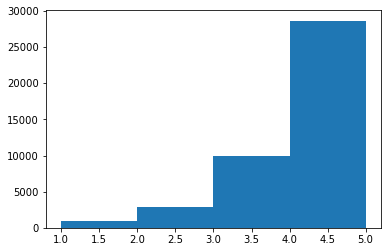

In [11]:
plt.hist(is_read_df['rating'], bins=[1,2,3,4,5])
plt.show()

In [12]:
# Calculate average rating
avg_rating = np.mean(is_read_df['rating'])
avg_rating

3.8694423511680482

In [13]:
# Define user-book rating matrix
mat = pd.pivot(is_read_df, index='user_id', columns='book_id', values='rating')
mat.replace(0, np.nan, inplace=True)

In [14]:
mat

book_id,10000600,10001793,10004138,10025007,1002520,10025305,1002703,1003291,1003318,1003985,...,9961796,9972838,9972882,9975679,9978196,9988148,9989273,999346,9994194,9996853
user_id,,,,,,,,,,,,,,,,,,,,,
0097fcaad4be6976a4e91410cf300b3b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
012515e5802b2e0f42915118c90fa04b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
012aa353140af13109d00ca36cdc0637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0147285ddc6b8a9ae27f1829a0bac33a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
015cb45454dc70dfc692eb17745fc6c0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fe2746ac48c0ff728bf9d8475f3f42e8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fe899820b2beda4005fac3aa31c54c08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fe98878f73553cc022af2a3ef0bb56b4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Train/test split
train, test = sklearn.model_selection.train_test_split(is_read_df, test_size=0.1, random_state=1111)
train.shape, test.shape

((38217, 10), (4247, 10))

In [16]:
# Set all test values to nan
zipped_test = np.c_[test['user_id'], test['book_id'], test['rating']]
test_mask = np.full(mat.shape, False)
for i in range(len(zipped_test)):
    row_idx = mat.index.get_loc(zipped_test[i][0])
    col_idx = mat.columns.get_loc(zipped_test[i][1])
    test_mask[row_idx, col_idx] = True
test_actuals = np.array(mat)[test_mask] # Save test actuals
mat[test_mask] = np.nan

In [17]:
mat.at[zipped_test[0][0], zipped_test[0][1]]

nan

In [18]:
# Calculate sparsity of data
not_null = mat.count().sum()
sparsity = 1 - not_null / (mat.shape[0] * mat.shape[1])
sparsity

0.9968667691919713

In [19]:
mat.count().sort_values(ascending=False)

book_id
2767052     618
6148028     468
41865       467
7260188     437
11870085    329
           ... 
6319120       0
147894        0
11486357      0
904965        0
8202129       0
Length: 10006, dtype: int64

In [57]:
# Number of books with 0 ratings
(mat.count()==0).sum()

572

In [20]:
# Calculate average rating for each book over users
avg_book_rating = np.nanmean(mat, axis=0) # column avg r_j
# For empty columns, fill with avg rating
np.nan_to_num(avg_book_rating, copy=False, nan=avg_rating)

# Fill missing value with the appropriate average for that book
filled = np.where(np.isnan(mat), avg_book_rating, mat)

<ipython-input-20-9498d0462504>:2: RuntimeWarning: Mean of empty slice
  avg_book_rating = np.nanmean(mat, axis=0) # column avg r_j


In [21]:
# Remove from each user (row) the mean over all books
avg_user_rating = np.average(filled, axis=1) # row avg r_i
avg_user_rating_col_vec = avg_user_rating.reshape(len(avg_user_rating),1)
normalized = filled - avg_user_rating_col_vec

In [22]:
normalized

array([[ 0.20996769, -0.79003231,  1.20996769, ..., -1.79003231,
         0.20996769,  1.20996769],
       [ 0.21098751, -0.78901249,  1.21098751, ..., -1.78901249,
         0.21098751,  1.21098751],
       [ 0.21053535, -0.78946465,  1.21053535, ..., -1.78946465,
         0.21053535,  1.21053535],
       ...,
       [ 0.20775628, -0.79224372,  1.20775628, ..., -1.79224372,
         0.20775628,  1.20775628],
       [ 0.21008777, -0.78991223,  1.21008777, ..., -1.78991223,
         0.21008777,  1.21008777],
       [ 0.2128791 , -0.7871209 ,  1.2128791 , ..., -1.7871209 ,
         0.2128791 ,  1.2128791 ]])

In [23]:
normalized.shape

(1219, 10006)

In [24]:
# Perform SVD, decide on a rank k, and calculate a reduced rating matrix to remove noise
# Can use sparse matrix algorithms because of special structure
# How to choose k: if top few values are big and the rest are small, take the big values. So chose k=11
U, S, VT = scipy.sparse.linalg.svds(normalized, k=6) # CHANGE BACK TO k=11

In [25]:
#U, S, VT = np.linalg.svd(normalized) #k=10

# U = U[:, :9]
# S = S[:9]
# VT = VT[:9, :]

In [26]:
S

array([  20.14268633,   21.42003648,   23.61941949,   27.83439699,
         41.42732491, 2899.6861076 ])

In [27]:
U.shape, S.shape, VT.shape

((1219, 6), (6,), (6, 10006))

In [28]:
reduced_rating = U @ np.diag(S) @ VT

In [29]:
reduced_rating # SHOULD THIS BE >=1? Maybe not, because it's already been reduced

array([[ 0.209946  , -0.79022545,  1.21011744, ..., -1.78836591,
         0.209946  ,  1.21011744],
       [ 0.20984034, -0.79089135,  1.21057204, ..., -1.79211889,
         0.20984034,  1.21057204],
       [ 0.21023898, -0.78967036,  1.21014833, ..., -1.7902316 ,
         0.21023898,  1.21014833],
       ...,
       [ 0.20706355, -0.79314628,  1.20727337, ..., -1.78982108,
         0.20706355,  1.20727337],
       [ 0.21008405, -0.78982354,  1.20999164, ..., -1.79260692,
         0.21008405,  1.20999164],
       [ 0.21305531, -0.78736422,  1.21347484, ..., -1.79032049,
         0.21305531,  1.21347484]])

In [30]:
reduced_rating.shape

(1219, 10006)

In [31]:
# Calculate matrix product for dimensionality-reduced rating matrix
sqrtS = np.diag(np.sqrt(S))
meta_on_users = U @ np.transpose(sqrtS)
meta_on_items = sqrtS @ VT

In [32]:
meta_on_items

array([[-5.61739006e-04, -2.83784769e-05, -1.09509953e-03, ...,
        -1.32870508e-02, -5.61739006e-04, -1.09509953e-03],
       [-5.81308604e-04, -1.19601683e-04, -1.04301552e-03, ...,
        -1.60017140e-04, -5.81308604e-04, -1.04301552e-03],
       [-8.24661904e-03, -6.89397003e-03, -9.59926805e-03, ...,
         1.12533209e-02, -8.24661904e-03, -9.59926805e-03],
       [ 4.14814558e-03,  2.78095001e-03,  5.51534116e-03, ...,
         3.26812328e-03,  4.14814558e-03,  5.51534116e-03],
       [ 5.64830007e-03,  5.66838068e-03,  5.62821946e-03, ...,
         6.80101783e-03,  5.64830007e-03,  5.62821946e-03],
       [ 1.36370300e-01, -5.12004765e-01,  7.84745364e-01, ...,
        -1.16038062e+00,  1.36370300e-01,  7.84745364e-01]])

In [33]:
# # Calculate similarity of 2 books j and f based on the reduced rating matrix
# # Similarity is the correlation of 2 movies based on average over users
# def similarity(j, f, matrix):
#     j_col = matrix[:, j]
#     f_col = matrix[:, f]
#     numerator = np.sum(np.multiply(j_col, f_col))
#     denominator = np.sqrt(np.multiply(np.sum(np.square(j_col)), np.sum(np.square(f_col))))
#     return numerator / denominator

In [34]:
# num_books = reduced_rating.shape[1]
# t1 = time()
# similarities = np.zeros((num_books, num_books))
# # TODO: is there a faster way to do this?
# for i in range(num_books):
#     for j in range(num_books):
#         similarities[i, j] = similarity(i, j, meta_on_items)
# t2 = time()

In [35]:
# t2-t1

In [36]:
# num_books = reduced_rating.shape[1]
# t1 = time()
# col_prods = meta_on_items.T.dot(meta_on_items)

# similarities2 = np.zeros((num_books, num_books))
# # TODO: is there a faster way to do this?
# for i in range(num_books):
#     for j in range(i, num_books):
#         similarities2[i, j] = col_prods[i, j] / np.sqrt(col_prods[i, i] * col_prods[j, j])
#         similarities2[j, i] = similarities2[i, j]
# t2 = time()

In [37]:
# similarities.shape, t2-t1, np.allclose(similarities, similarities2)

In [38]:
num_books = reduced_rating.shape[1]
t1 = time()
similarities = pw.cosine_similarity(meta_on_items.T, meta_on_items.T)
t2 = time()

In [39]:
similarities.shape, t2-t1

((10006, 10006), 0.14583039283752441)

In [40]:
# # Without reducing dimensionality
# num_books = reduced_rating.shape[1]
# t1 = time()
# similarities = pw.cosine_similarity(reduced_rating.T, reduced_rating.T)
# t2 = time()
# similarities.shape, t2-t1

In [41]:
# # TODO: try optimizing
# # Calculate prediction of rating by user i of book j, by avging over the ratings of all books by the same user, each weighted according to its similarity to book j
# num_users = reduced_rating.shape[0]
# predictions = np.zeros((num_users, num_books))

# # Isolate the set of items which appear to be the most similar to the active item. Vozalis suggests 10 items is best.
# most_similar_idx = np.argsort(similarities, axis=1)[:,-10:]
# for a in range(num_users):
#     for j in range(num_books):
#         numerator = 0
#         denominator = 0
#         # check that similarities are non-negative
#         for k in most_similar_idx[j,:]:
#             sim = similarities[j,k]
#             if sim < 0:
#                 break
#             numerator += sim * (reduced_rating[a,k] + avg_user_rating[a])
#             denominator += sim
#         predictions[a,j] = numerator/denominator

In [45]:
def rearrange_cols(arr, idx):
    rows = np.indices(idx.shape)[0]
    return arr[rows, idx]

# Calculate prediction of rating by user i of book j, by avging over the ratings of all books by the same user, each weighted according to its similarity to book j
num_users = reduced_rating.shape[0]
predictions = np.zeros((num_users, num_books))

# Isolate the set of items which appear to be the most similar to the active item. Vozalis suggests 10 items is best.
t1 = time()
most_similar_idx = np.argsort(similarities, axis=1)[:,:-11:-1]
adjusted_rating = reduced_rating + avg_user_rating[:,np.newaxis]
nonneg_sims = np.where(similarities > 0, similarities, 0)
sorted_sims = rearrange_cols(nonneg_sims, most_similar_idx)
denominator = np.sum(sorted_sims, axis=1)
for a in range(num_users):
    for j in range(num_books):
        numerator = 0
        for k in most_similar_idx[j,:]:
            numerator += nonneg_sims[j,k] * adjusted_rating[a,k]
        predictions[a,j] = numerator/denominator[j]
t2 = time()
t2-t1

150.19122314453125

In [46]:
print(np.min(predictions), np.max(predictions))
predictions

0.9869462914225018 5.101125038034682


array([[3.99997831, 2.99980686, 5.00014976, ..., 2.40107635, 3.99997831,
        5.00014976],
       [3.99885284, 2.99812114, 4.99958453, ..., 2.39751921, 3.99885284,
        4.99958453],
       [3.99970363, 2.99979429, 4.99961297, ..., 2.39944588, 3.99970363,
        4.99961297],
       ...,
       [3.99930726, 2.99909744, 4.99951708, ..., 2.40191302, 3.99930726,
        4.99951708],
       [3.99999627, 3.00008869, 4.99990386, ..., 2.39833161, 3.99999627,
        4.99990386],
       [4.00017621, 2.99975668, 5.00059574, ..., 2.39715546, 4.00017621,
        5.00059574]])

In [47]:
np.shape(predictions)

(1219, 10006)

In [48]:
# Define error function
def rmse(predictions, actuals):
    return np.sqrt(((predictions - actuals) ** 2).mean())

In [49]:
# Calculate training error
training_mask = np.array(mat.notna())
train_predictions = predictions[training_mask]
train_actuals = np.array(mat)[training_mask]
train_rmse = rmse(train_predictions, train_actuals)
train_rmse

0.810846407349137

In [50]:
train_predictions, train_actuals

(array([3.96640918, 4.44333669, 4.42464842, ..., 3.98759445, 3.61870703,
        3.60235035]),
 array([5., 5., 5., ..., 4., 2., 3.]))

In [51]:
# Calculate test error
#zipped_test = np.c_[test['user_id'], test['book_id'], test['rating']]
test_predictions = predictions[test_mask]
test_rmse = rmse(test_predictions, test_actuals)
test_rmse

1.0232062453487905

In [52]:
test_predictions[:10], test_actuals[:10]

(array([3.91033426, 3.96774087, 4.02746113, 3.92615906, 3.99885284,
        3.68779743, 4.1654636 , 3.97184558, 3.99606243, 3.89449871]),
 array([5., 5., 5., 5., 4., 4., 4., 5., 5., 5.]))

In [53]:
# Calculate error if just rated everything the avg rating
avg_train = np.full(train_actuals.shape, avg_rating)
avg_train_rmse = rmse(avg_train, train_actuals)
avg_test = np.full(test_actuals.shape, avg_rating)
avg_test_rmse = rmse(avg_test, test_actuals)
avg_train_rmse, avg_test_rmse

(1.0065748449630971, 1.0168112026908493)

# Debugging

In [ ]:
np.argsort(similarities, axis=0)

In [ ]:
testing = np.array([[1,5,8,3,7],[1,2,3,4,5]])
sorted_testing = np.argsort(testing, axis=1)
sorted_testing[:,-2:]

In [ ]:
np.all(predictions < 5), np.all(predictions > 1)

In [ ]:
np.all(reduced_rating < 5), np.all(reduced_rating > 1)

In [ ]:
reduced_rating

In [ ]:
avg_user_rating